In [1]:
import torch    
import json 
from ptlpinns.models import model, transfer
from ptlpinns.perturbation import LPM, standard
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

### Load model

In [2]:
name = "overdamped_k15"

overdamped_path = f"/home/dda24/PTL-PINNs/ptlpinns/models/train/{name}"
overdamped_name = f"model_{name}.pth"
overdamped_model, training_log = model.load_model(overdamped_path, overdamped_name)

15 True True False [128, 128, 256]


### Problem definition

In [3]:
N = 5120
t_span = (0, 20)
t_eval = np.linspace(t_span[0], t_span[1], N)

### Compute latent representations

In [4]:
H_dict = transfer.compute_H_dict(overdamped_model, N=N, bias=True, t_span=t_span)

### Transfer parameters

In [5]:
w_list_transfer = [1, 1, 1, 1, 1]
zeta_list = [5, 10, 30, 60]

def forcing(numpy=False):
    if not numpy:
        def force(t):
            return torch.stack((torch.zeros_like(t), torch.cos(t)), dim=1)
    else:
        def force(t):
            return np.stack((np.zeros_like(t), np.cos(t)), axis=1)
    return force

forcing_list = [forcing(True), forcing(True), forcing(True), forcing(True), forcing(True)]

forcing_1D = lambda t: np.cos(t)
ic_list = [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
epsilon_list = [0.5, 0.5, 0.5, 0.5, 0.5]
p_list = [10]
q = [(3, 1)]

### Numerical solver

In [6]:
numerical_list = []

for zeta in zeta_list:
    ode = equations.ode_oscillator_1D(w_0=w_list_transfer[0], zeta=zeta, forcing_1D=forcing_1D, q=q, epsilon=epsilon_list[0])
    numerical_list.append(numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic_list[0]))

### PINN

In [7]:
NN_TL_solution, perturbation_solution, _ = transfer.compute_perturbation_solution(w_list_transfer, zeta_list, epsilon_list, p_list, ic_list, forcing_list, H_dict, t_eval, training_log, all_p=True, comp_time=False, solver="standard", power=q)
NN_TL_solution = NN_TL_solution.squeeze()

In [8]:
NN_TL_solution.shape

(5120, 4, 2)

In [9]:
PINN_solution = []

for perturbation_zeta in perturbation_solution:

    perturbation = []
    for perturbation_order in perturbation_zeta:

        perturbation.append(perturbation_order[:, 0])

    PINN_solution.append(standard.calculate_general_series(perturbation, epsilon_list[0]))

zeta: 5, order: 0, mean error absolute: 0.05822672219911064
zeta: 5, order: 1, mean error absolute: 0.01621924514273289
zeta: 5, order: 2, mean error absolute: 0.005581307697008165
zeta: 5, order: 3, mean error absolute: 0.002127104072617567
zeta: 5, order: 4, mean error absolute: 0.0008619182111754362
zeta: 5, order: 5, mean error absolute: 0.0003652541952182439
zeta: 5, order: 6, mean error absolute: 0.00016114762129235276
zeta: 5, order: 7, mean error absolute: 7.51443933448086e-05
zeta: 5, order: 8, mean error absolute: 4.213426600121563e-05
zeta: 5, order: 9, mean error absolute: 3.226902198947336e-05


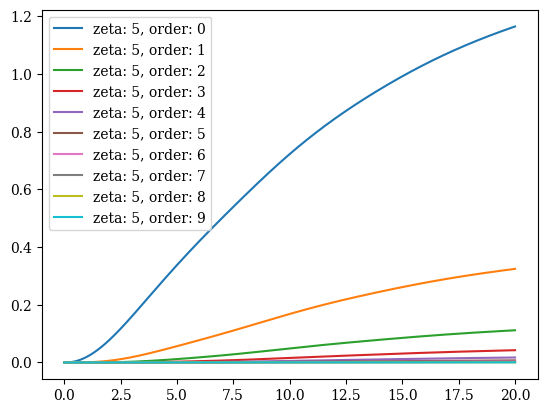

zeta: 10, order: 0, mean error absolute: 0.06638857482350895
zeta: 10, order: 1, mean error absolute: 0.015076295966738384
zeta: 10, order: 2, mean error absolute: 0.004242890169006312
zeta: 10, order: 3, mean error absolute: 0.0013468825183748107
zeta: 10, order: 4, mean error absolute: 0.0004603649134586062
zeta: 10, order: 5, mean error absolute: 0.00019677026790536654
zeta: 10, order: 6, mean error absolute: 0.00012482212051906312
zeta: 10, order: 7, mean error absolute: 0.00011018457288589621
zeta: 10, order: 8, mean error absolute: 0.00010669910854877127
zeta: 10, order: 9, mean error absolute: 0.00010605920631716952


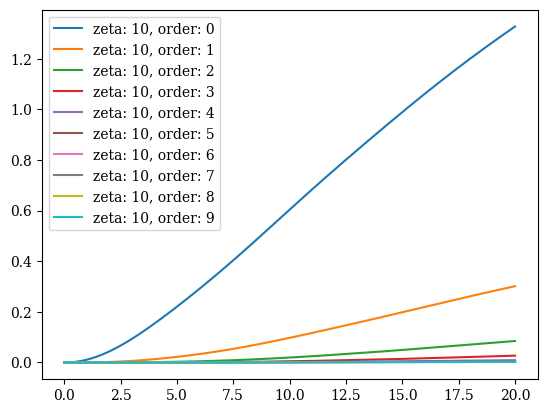

zeta: 30, order: 0, mean error absolute: 0.04891298451529012
zeta: 30, order: 1, mean error absolute: 0.006095791071199535
zeta: 30, order: 2, mean error absolute: 0.0008547358934589824
zeta: 30, order: 3, mean error absolute: 0.00027796058963721373
zeta: 30, order: 4, mean error absolute: 0.00011833752885396384
zeta: 30, order: 5, mean error absolute: 0.00013994016979622509
zeta: 30, order: 6, mean error absolute: 0.00013419340465164103
zeta: 30, order: 7, mean error absolute: 0.00013534169218918756
zeta: 30, order: 8, mean error absolute: 0.00013509951530534683
zeta: 30, order: 9, mean error absolute: 0.00013515060978583495


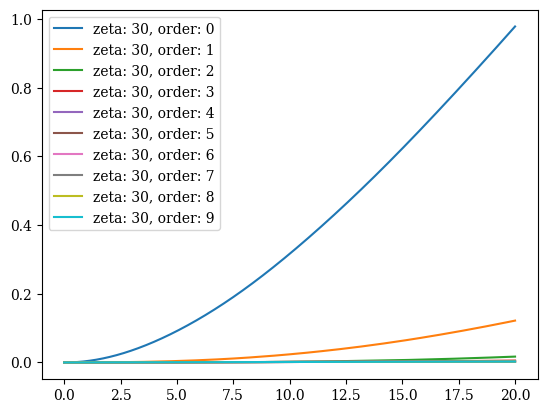

zeta: 60, order: 0, mean error absolute: 0.031390431416375694
zeta: 60, order: 1, mean error absolute: 0.0022847372586345845
zeta: 60, order: 2, mean error absolute: 0.00017514875993349677
zeta: 60, order: 3, mean error absolute: 8.117966420830071e-05
zeta: 60, order: 4, mean error absolute: 5.999311460552596e-05
zeta: 60, order: 5, mean error absolute: 6.226296425781863e-05
zeta: 60, order: 6, mean error absolute: 6.200784636954998e-05
zeta: 60, order: 7, mean error absolute: 6.203741356467436e-05
zeta: 60, order: 8, mean error absolute: 6.203390470695708e-05
zeta: 60, order: 9, mean error absolute: 6.203432892894935e-05


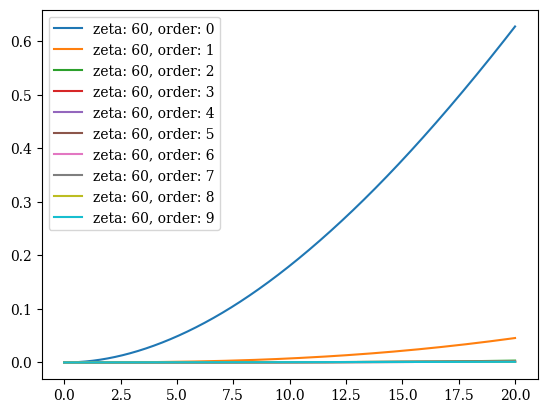

In [10]:
standard.plot_error_by_order(t_eval, PINN_solution, numerical_list, p_list, zeta_list, "zeta")

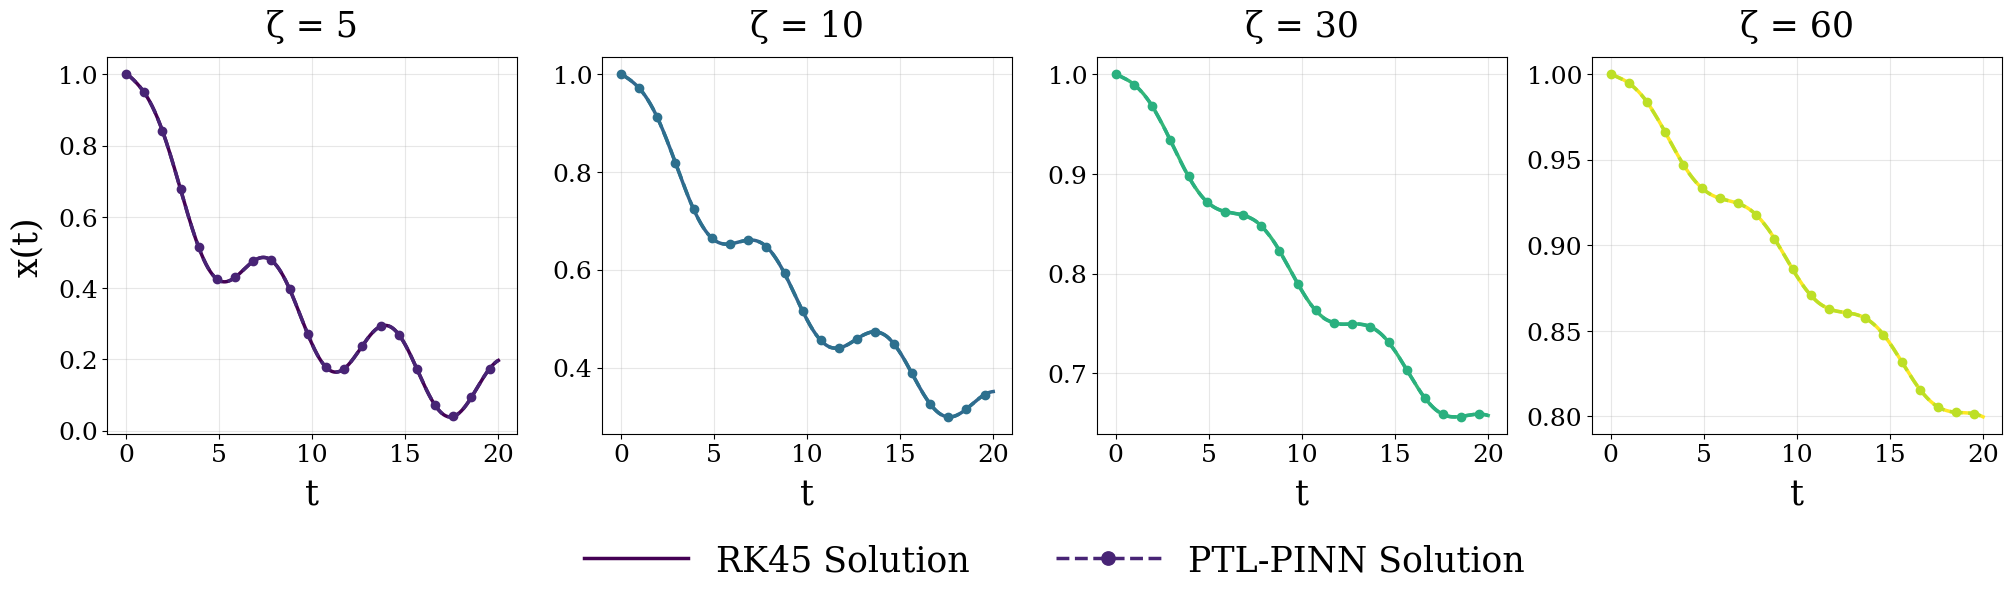

In [11]:
standard.plot_compare_multiple_zeta(t_eval, zeta_list, numerical_list, NN_TL_solution)


zeta: 5, mean Error: 3.032e-05
zeta: 10, mean Error: 1.058e-04
zeta: 30, mean Error: 1.351e-04
zeta: 60, mean Error: 6.203e-05


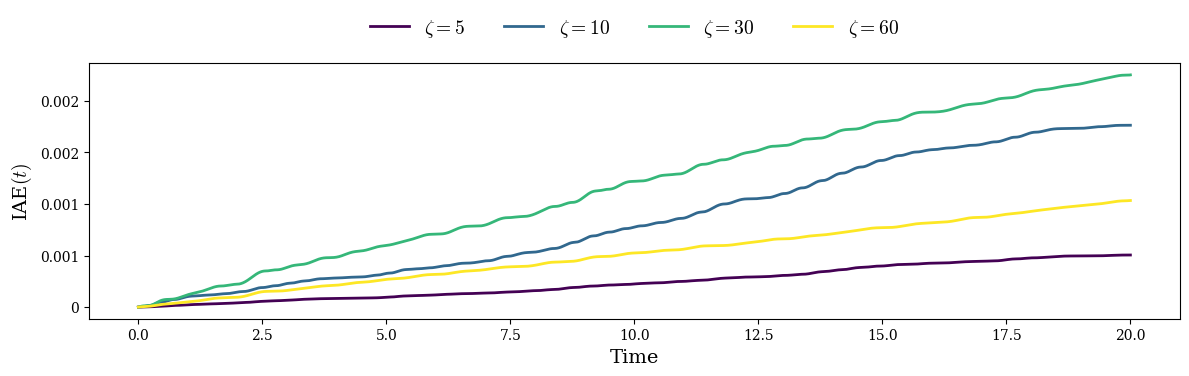

In [12]:
standard.plot_IAE_multiple_zeta(zeta_list, t_eval, NN_TL_solution, numerical_list)